# NeRF: Neural Radiance Field

This is my implementation of the NeRF algorithm, using Pytorch

References:
- [Project Website](http://www.matthewtancik.com/nerf)
- [arXiv Paper](https://arxiv.org/abs/2003.08934)



In [1]:
import numpy as np
import copy
import torch
import open3d as o3d
import matplotlib.pyplot as plt
#from utils import o3d_form_mesh, o3d_render, load_obj
from utils import o3d_form_mesh, load_obj


c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [34]:
vis = o3d.visualization.Visualizer()
vis.create_window(width=10, height=10, visible = False)

ctr = vis.get_view_control()

init_param = ctr.convert_to_pinhole_camera_parameters()
w, h = 4000, 3000
fx = 1
fy = 1
cx = 1
cy = 1
init_param.intrinsic.width = w
init_param.intrinsic.height = h
init_param.intrinsic.set_intrinsics(init_param.intrinsic.width, init_param.intrinsic.height, fx, fy, cx, cy)
init_param.extrinsic = 2
ctr.convert_from_pinhole_camera_parameters(init_param)



TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.camera.PinholeCameraParameters, arg0: numpy.ndarray[float64[4, 4]]) -> None

Invoked with: PinholeCameraParameters class.
Access its data via intrinsic and extrinsic., 2

## Load example mesh

ViewControl


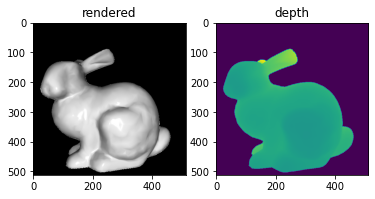

In [29]:
# load an example 3D mesh

def o3d_render(mesh, width=512, height=512, normal=False):
    # render the tri-mesh using open3d

    mesh.compute_triangle_normals()
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    
    print(vis.get_view_control())
    
    opt = vis.get_render_option()
    if normal:
        # use surface normal as texture
        opt.mesh_color_option = o3d.visualization.MeshColorOption.Normal
    vis.add_geometry(mesh)
    # smooth shading
    opt.mesh_shade_option = o3d.visualization.MeshShadeOption.Color
    depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)
    return np.asarray(image), np.asarray(depth)
    """
    # Create a renderer with the desired image size
    img_width = width
    img_height = height
    render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

    # Define a simple unlit Material.
    # (The base color does not replace the arrows' own colors.)
    mtl = o3d.visualization.rendering.Material()
    mtl.shader = "defaultUnlit"
    #mtl.base_color = [0,0,0,1]  # RGBA

    render.scene.add_geometry("rotated_model", mesh, mtl)

    # Since the arrow material is unlit, it is not necessary to change the scene lighting.
    #render.scene.scene.enable_sun_light(False)
    #render.scene.set_lighting(render.scene.LightingProfile.NO_SHADOWS, (0, 0, 0))

    # Optionally set the camera field of view (to zoom in a bit)
    vertical_field_of_view = 15.0  # between 5 and 90 degrees
    aspect_ratio = img_width / img_height  # azimuth over elevation
    near_plane = 0.1
    far_plane = 50.0
    fov_type = o3d.visualization.rendering.Camera.FovType.Vertical
    render.scene.camera.set_projection(vertical_field_of_view, aspect_ratio, near_plane, far_plane, fov_type)

    # Look at the origin from the front (along the -Z direction, into the screen), with Y as Up.
    center = [-0.01, 0.1, 0]  # look_at target
    eye = [0, 0, 1]  # camera position
    up = [0, 1, 0]  # camera orientation
    render.scene.camera.look_at(center, eye, up)

    # Read the image into a variable
    img_o3d = render.render_to_image()
    
    return np.asarray(img_o3d), np.ones([height, width])
    """

V, T, F = load_obj('./bunny.obj')
#V[:,2] += 6
mesh = o3d_form_mesh(V, T, F)

img, dpt = o3d_render(mesh, width=512, height=512, normal=False)

# mask the background
mask = dpt > 0
for c in range(3):
    img[...,c] *= mask

plt.subplot(1,2,1); plt.title('rendered'); plt.imshow(img)
plt.subplot(1,2,2); plt.title('depth'); plt.imshow(dpt)

    

## Interact with distance, elevation, and azimuth

[[ 0.9553365   0.         -0.29552022  0.        ]
 [-0.0873322   0.9553365  -0.28232124  0.        ]
 [ 0.28232124  0.29552022  0.9126679   2.        ]
 [ 0.          0.          0.          1.        ]]


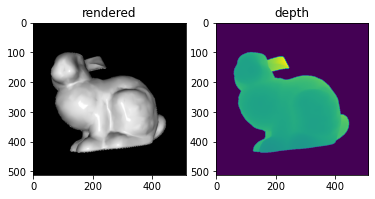

In [24]:
# Distance
trans_t = lambda t : np.array(
    [[1,0,0,0],
     [0,1,0,0],
     [0,0,1,t],
     [0,0,0,1]], dtype=np.float32)

# Elevation
rot_phi = lambda phi : np.array(
    [[1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]], dtype=np.float32)

# Azimuth
rot_theta = lambda th : np.array(
    [[np.cos(th),0,-np.sin(th),0],
     [0,1,0,0],
     [np.sin(th),0, np.cos(th),0],
     [0,0,0,1]], dtype=np.float32)

def pose_matrix(t, phi, th):
    # phi and th should be in 0 ~ 2pi
    pose = trans_t(t) @ rot_phi(phi) @ rot_theta(th)
    return pose

pose = pose_matrix(2.0, 0.3, 0.3)
print(pose)
mesh = o3d_form_mesh(V@pose[:3,:3]+pose[:3,3].T, T, F)

img, dpt = o3d_render(mesh, width=512, height=512, normal=False)

# mask the background
mask = dpt > 0
for c in range(3):
    img[...,c] *= mask

plt.subplot(1,2,1); plt.title('rendered'); plt.imshow(img)
plt.subplot(1,2,2); plt.title('depth'); plt.imshow(dpt)

In [32]:
V@pose[:3,:3]# +pose[:3,3].T

array([[-0.00849724,  0.1309279 , -0.01592969],
       [-0.08301504,  0.15445418,  0.00816143],
       [-0.03976643,  0.11953037, -0.02519908],
       ...,
       [-0.03411752,  0.15390287, -0.06327224],
       [-0.09209319,  0.13130249, -0.06282814],
       [-0.05278962,  0.0597712 ,  0.01559268]])